In [1]:
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets
data = datasets.load_diabetes()

features_in_different_scale = True

if features_in_different_scale:
    data["data"][:, 0] = 100*data["data"][:, 0]
    data["data"][:, 1] = 10*data["data"][:, 1]
    data["data"][:, 2] = 0.01*data["data"][:, 2]
    data["data"][:, 3] = 100000*data["data"][:, 3]


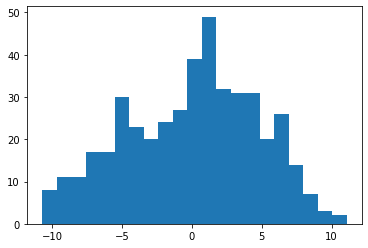

In [3]:
plt.hist(data["data"][:, 0], bins=21);

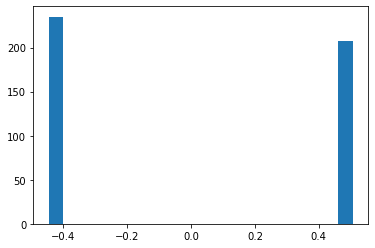

In [4]:
plt.hist(data["data"][:, 1], bins=21);

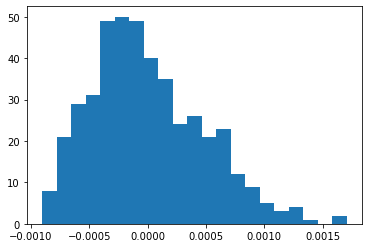

In [5]:
plt.hist(data["data"][:, 2], bins=21);

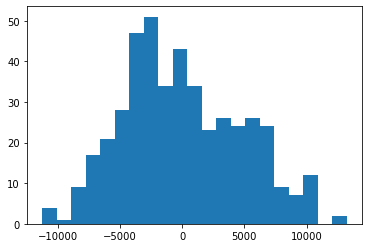

In [6]:
plt.hist(data["data"][:, 3], bins=21);

In [7]:
import torch

# define a floating point model where some layers could be statically quantized
class M(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # QuantStub converts tensors from floating point to quantized
        self.quant = torch.ao.quantization.QuantStub()
        self.lin1 = torch.nn.Linear(10, 128) #10 input features
        self.relu = torch.nn.ReLU()
        self.lin2 = torch.nn.Linear(128, 1) #1 regression output
        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)
        return x

In [8]:
model_fp32 = M()
optimizer = torch.optim.AdamW(model_fp32.parameters(), lr=0.005)
for epoch in range(1000):
    optimizer.zero_grad()
    out = model_fp32(torch.tensor(data["data"]).to(dtype=torch.float))
    loss = torch.nn.functional.mse_loss(out[:, 0], torch.tensor(data["target"]).to(torch.float))
    loss.backward()
    if epoch%100 == 0:
        print(epoch, loss.detach().cpu().item())
    optimizer.step()

0 115291.0625
100 10960.3349609375
200 10751.10546875
300 10522.376953125
400 10241.099609375
500 9781.6552734375
600 9001.2080078125
700 7947.12060546875
800 6948.81298828125
900 6115.92822265625


In [9]:
import matplotlib.pyplot as plt

In [10]:
out = model_fp32(torch.tensor(data["data"]).to(torch.float)).detach().cpu().numpy()[:, 0]

(0.0, 400.0)

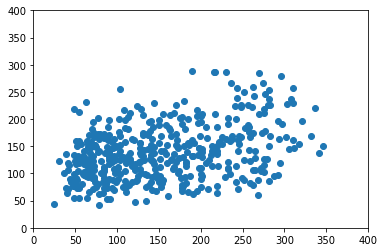

In [11]:
plt.scatter(data["target"], out)
plt.xlim(0,400)
plt.ylim(0,400)

In [12]:
# model must be set to eval mode for static quantization logic to work
model_fp32.eval()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'x86' for server inference and 'qnnpack'
# for mobile inference. Other quantization configurations such as selecting
# symmetric or asymmetric quantization and MinMax or L2Norm calibration techniques
# can be specified here.
# Note: the old 'fbgemm' is still available but 'x86' is the recommended default
# for server inference.
# model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')
model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('x86')

# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`
#model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32, [])

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_fp32_prepared = torch.ao.quantization.prepare(model_fp32)

input_fp32 = torch.tensor(data["data"]).to(torch.float)
# calibrate the prepared model to determine quantization parameters for activations
# in a real world setting, the calibration would be done with a representative dataset
model_fp32_prepared(input_fp32)

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

# run the model, relevant calculations will happen in int8
out_quantized = model_int8(input_fp32)[:, 0]

/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


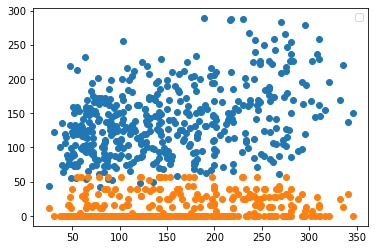

In [13]:
plt.scatter(data["target"], out, )
plt.scatter(data["target"], out_quantized)
plt.legend(loc="best")

In [14]:
model_int8.quant

Quantize(scale=tensor([192.3804]), zero_point=tensor([58]), dtype=torch.quint8)

In [15]:
x1 = model_int8.quant(input_fp32)
x1

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], size=(442, 10), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=192.38037109375,
       zero_point=58)

In [16]:
model_int8.lin1

QuantizedLinear(in_features=10, out_features=128, scale=58.23945617675781, zero_point=64, qscheme=torch.per_channel_affine)

In [17]:
x2 = model_int8.lin1(x1)
x2

tensor([[-524.1551, -640.6340, -174.7184,  ..., -116.4789, -349.4367,
         -582.3945],
        [ 640.6340,  815.3524,  174.7184,  ...,  174.7184,  465.9156,
          757.1129],
        [ 116.4789,  174.7184,   58.2395,  ...,   58.2395,  116.4789,
          174.7184],
        ...,
        [-407.6762, -524.1551, -116.4789,  ..., -116.4789, -291.1973,
         -465.9156],
        [ -58.2395,  -58.2395,    0.0000,  ...,    0.0000,    0.0000,
          -58.2395],
        [1863.6626, 2387.8176,  524.1551,  ...,  465.9156, 1339.5074,
         2213.0994]], size=(442, 128), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=58.23945617675781,
       zero_point=64)

In [18]:
x3 = model_int8.relu(x2)
x3

tensor([[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [ 640.6340,  815.3524,  174.7184,  ...,  174.7184,  465.9156,
          757.1129],
        [ 116.4789,  174.7184,   58.2395,  ...,   58.2395,  116.4789,
          174.7184],
        ...,
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [1863.6626, 2387.8176,  524.1551,  ...,  465.9156, 1339.5074,
         2213.0994]], size=(442, 128), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=58.23945617675781,
       zero_point=64)

In [19]:
model_int8.lin2

QuantizedLinear(in_features=128, out_features=1, scale=2.273333787918091, zero_point=0, qscheme=torch.per_channel_affine)

In [20]:
x4 = model_int8.lin2(x3)
x4[:10]

tensor([[ 0.0000],
        [ 0.0000],
        [56.8333],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [31.8267],
        [ 0.0000],
        [ 0.0000]], size=(10, 1), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=2.273333787918091,
       zero_point=0)

In [21]:
model_int8.dequant

DeQuantize()

In [22]:
x5 = model_int8.dequant(x4)

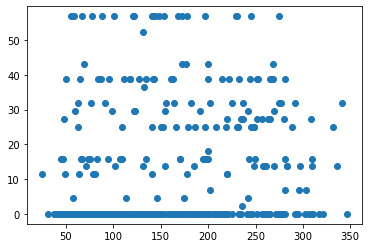

In [23]:
plt.scatter(data["target"], x5[:, 0])